In [1]:
# Importing libraries 

import numpy as np                             # numpy = numerical python
import os                                      # os = operating system
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'       # prevent debuging information to be printed
import tensorflow as tf                        # tensorflow = library for machine learning
import time                                    # time allows to access the 
from IPython import display                    # interacting with terminal
import matplotlib.pyplot as plt                # used to plot images and graphs
import pandas as pd

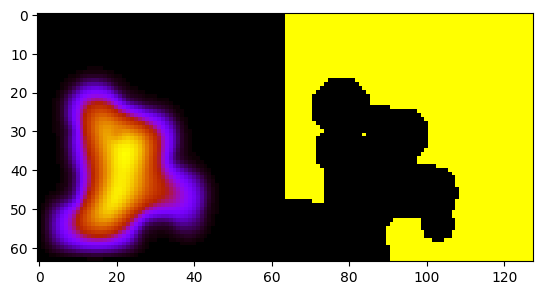

In [7]:
imageNumber = 139                                                           # Choose a number between 1 and 4800
testImage = train_dataset = np.load("./Data/train/"+str(imageNumber)+".npy") # Loading Imaage
plt.imshow(testImage,cmap="gnuplot", interpolation="none");                  # Plotting image

In [8]:

# Function for splitting the input and output.
def split(image):
    w = tf.shape(image)[1]
    w = w // 2

    input_image = image[:, w:, :]
    real_image = image[:, :w, :]

    input_image = tf.cast(input_image, tf.float32)
    real_image = tf.cast(real_image, tf.float32)

    return input_image, real_image


2024-07-05 15:07:35.953160: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


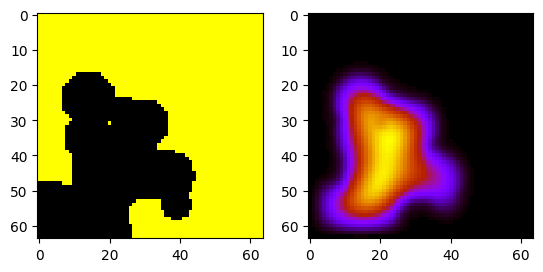

In [9]:
# Testing the splitting function for above image

inputSplit, outputSplit = split(testImage)
fig, axs = plt.subplots(1,2)
axs[0].imshow(inputSplit, cmap="gnuplot", interpolation="none");
axs[1].imshow(outputSplit, cmap="gnuplot", interpolation="none");

In [10]:
IMG_WIDTH = 64       # The width of the image (px).
IMG_HEIGHT = 64      # The height of the image (px).
IRP = 64             # The image resize for Jittering process.

In [11]:
# Resizing image to the given height, width.

def resize(input_image, real_image, height, width):
    input_image = tf.image.resize(
        input_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    real_image = tf.image.resize(
        real_image, [height, width], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    return input_image, real_image

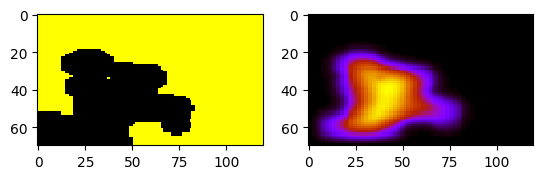

In [12]:
# Testing the resize function for above image

inputResize, outputResize = resize(inputSplit,outputSplit, 70,120) # Modify 70 and 120 to whatever
fig, axs = plt.subplots(1,2)
axs[0].imshow(inputResize, cmap="gnuplot", interpolation="none");
axs[1].imshow(outputResize, cmap="gnuplot", interpolation="none");

In [13]:
# Randomply cropping function for resized image.
def random_crop(input_image, real_image,width=IMG_HEIGHT,height=IMG_WIDTH):
    stacked_image = tf.stack([input_image, real_image], axis=0)
    cropped_image = tf.image.random_crop(
        stacked_image, size=[2, width, height, 1]
    )
    return cropped_image[0], cropped_image[1]

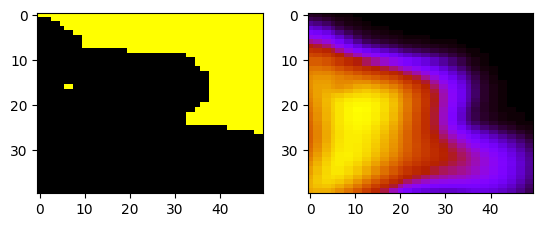

In [14]:
# Testing the resize function for above image

inputCropped, outputCropped = random_crop(inputResize,outputResize,40,50) # Modify 60 and 50 to whatever
fig, axs = plt.subplots(1,2)
axs[0].imshow(inputCropped, cmap="gnuplot", interpolation="none")
axs[1].imshow(outputCropped, cmap="gnuplot", interpolation="none");

In [15]:
# Normalizing images between [-1, 1]. Min-Max from images:[0,255].

def normalize(input_image, real_image):
    input_image = (input_image / 127.5) - 1
    real_image = (real_image / 127.5) - 1

    return input_image, real_image

In [16]:
# Jittering, resizing image and randomly cropping back to the original size.

@tf.function()
def random_jitter(input_image, real_image, rand_crop = IRP):
    input_image, real_image = resize(input_image, real_image, rand_crop,rand_crop)  # First resize
    input_image, real_image = random_crop(input_image, real_image)                  # Then Random crop

    if tf.random.uniform(()) > 0.5:                             # Random number for flipping or not
        input_image = tf.image.flip_left_right(input_image)     # Flip Input
        real_image = tf.image.flip_left_right(real_image)       # Flip Output

    return input_image, real_image

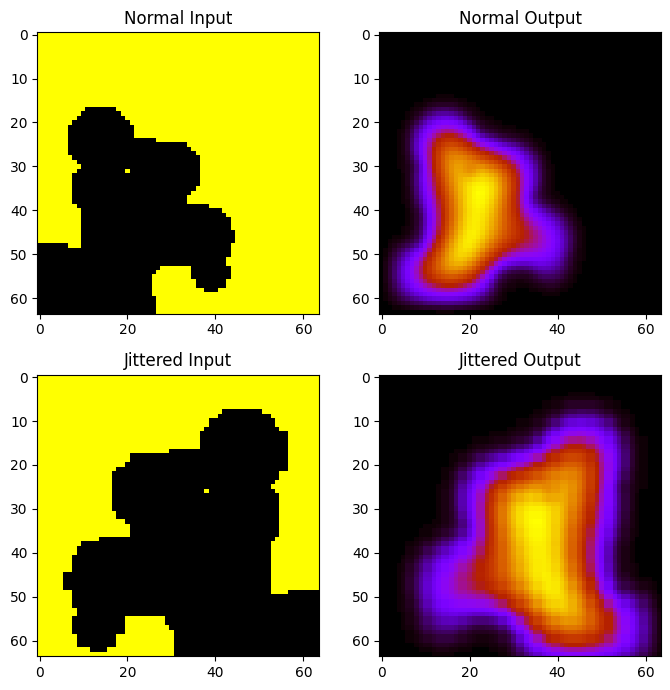

In [17]:
# Testing Jittering 

inputJitter, outputJitter = random_jitter(inputSplit,outputSplit,85)  # Modify 85
fig, axs = plt.subplots(2,2, figsize=(7,7))
axs[0,0].imshow(inputSplit, cmap="gnuplot", interpolation="none")
axs[0,1].imshow(outputSplit, cmap="gnuplot", interpolation="none")
axs[1,0].imshow(inputJitter, cmap="gnuplot", interpolation="none")
axs[1,1].imshow(outputJitter, cmap="gnuplot", interpolation="none");
axs[0,0].set_title("Normal Input")
axs[0,1].set_title("Normal Output")
axs[1,0].set_title("Jittered Input")
axs[1,1].set_title("Jittered Output")
plt.tight_layout()

In [18]:
# Processing the train data_set.
def process_image_train(image_data):
    input_image, real_image = split(image_data)                         # Split
    input_image, real_image = random_jitter(input_image, real_image)    # Jittering
    input_image, real_image = normalize(input_image, real_image)        # Normalize

    return input_image, real_image

In [19]:
# Processing both validation and test data sets.
def process_image_test(image_data):
    input_image, real_image = split(image_data)                                         # Split
    input_image, real_image = resize(input_image, real_image, IMG_HEIGHT, IMG_WIDTH)    # Resize
    input_image, real_image = normalize(input_image, real_image)                        # Normalize

    return input_image, real_image

In [20]:
# Loading data from the folder 'Data', whish contain train, test and validation.
def loadData(folder, quantity):
    return [np.load("Data/" + folder + "/" + str(i) + ".npy") for i in range(quantity)]

In [21]:
BUFFER_SIZE = 4800   # Number of images for a shuffling process.
BATCH_SIZE = 1       # Number of images in a trining step.

In [22]:
# Loading train data set.
train_dataset = loadData("train", 4800);                              # Load Data
train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset);    # Transform to dataset
train_dataset = train_dataset.map(process_image_train);               # Split Jittering, Normalize
train_dataset = train_dataset.shuffle(BUFFER_SIZE);                   # Shuffle
train_dataset = train_dataset.batch(BATCH_SIZE);                      # Batching
print("Train data_set:", np.shape(list(train_dataset.as_numpy_iterator())))

Train data_set: (4800, 2, 1, 64, 64, 1)


In [23]:
# Loading validation data set.
validation_dataset = loadData("validation", 100);                               # Load Data
validation_dataset = tf.data.Dataset.from_tensor_slices(validation_dataset);    # Transform to dataset                       
validation_dataset = validation_dataset.map(process_image_test);                # Split Jittering, Normalize             
validation_dataset = validation_dataset.batch(BATCH_SIZE);                      #  Batching       
print("Validation data_set:", np.shape(list(validation_dataset.as_numpy_iterator())))

# Loading test data set.
test_dataset = loadData("test", 100);                                         # Load Data  
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset);              # Transform to dataset           
test_dataset = test_dataset.map(process_image_test);                          # Split Jittering, Normalize   
test_dataset = test_dataset.batch(BATCH_SIZE);                                #  Batching          
print("Test data_set:", np.shape(list(test_dataset.as_numpy_iterator())))

Validation data_set: (100, 2, 1, 64, 64, 1)
Test data_set: (100, 2, 1, 64, 64, 1)


In [24]:
OUTPUT_CHANNELS = 1  # Output channels RGB: (3 for colored images, 1 for gray scale)

In [25]:
# Defining the downsample function for the encoder.
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0.0, 0.02)

    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2D(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    if apply_batchnorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(tf.keras.layers.LeakyReLU())

    return result


(32, 32)


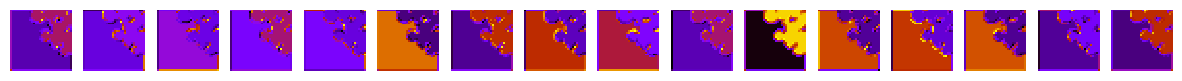

In [26]:
# Testing downsample 

deep = 16
down_model = downsample(deep, 4)
inp, tar  = split(loadData("train", 100)[9])
down_result = down_model(tf.expand_dims(inp, 0))

fig, axs = plt.subplots(1,deep,figsize=(15, 15))
axs[0].imshow(inp, cmap="gnuplot", interpolation="none")
axs[1].imshow(tar, cmap="gnuplot", interpolation="none")
axs[0].axis('off');

for i in range(deep):
    axs[i].imshow(down_result[0,:,:,i], cmap="gnuplot",interpolation="none")
    axs[i].axis('off');
print (down_result[0,:,:,1].shape)

In [27]:
# Upsample function for the decoder.
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0.0, 0.02)


    result = tf.keras.Sequential()
    result.add(
        tf.keras.layers.Conv2DTranspose(
            filters,
            size,
            strides=2,
            padding="same",
            kernel_initializer=initializer,
            use_bias=False,
        )
    )

    result.add(tf.keras.layers.BatchNormalization())

    if apply_dropout:
        result.add(tf.keras.layers.Dropout(0.5))

    result.add(tf.keras.layers.ReLU())

    return result



In [28]:
# U-Net generator
def Generator():
    inputs = tf.keras.layers.Input(shape=[64, 64, 1])

    down_stack = [
        downsample(16, 4, apply_batchnorm=False),  # (batch_size, 32, 32, 16)
        downsample(32, 4),  # (batch_size, 16, 16, 32)
        downsample(64, 4),  # (batch_size, 8, 8, 64)
        downsample(128, 4),  # (batch_size, 4, 4, 128)
        downsample(128, 4),  # (batch_size, 2, 2, 128)
        downsample(128, 4),  # (batch_size, 1, 1, 128)
    ]

    up_stack = [
        upsample(128, 4),  # (batch_size, 2, 2, 128)
        upsample(128, 4),  # (batch_size, 4, 4, 128)
        upsample(64, 4),  # (batch_size, 8, 8, 64)
        upsample(32, 4),  # (batch_size, 16, 16, 32)
        upsample(16, 4),  # (batch_size, 32, 32, 16)
    ]

    initializer = tf.random_normal_initializer(0.0, 0.02)
    last = tf.keras.layers.Conv2DTranspose(
        OUTPUT_CHANNELS,
        4,
        strides=2,
        padding="same",
        kernel_initializer=initializer,
        activation="tanh",
    )  # (batch_size, 64, 64, 1)

    x = inputs
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = tf.keras.layers.Concatenate()([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

generator = Generator()

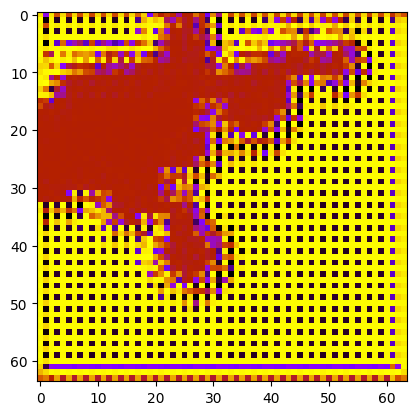

In [29]:
# Testing Generator

inp, tar =  split(loadData("train", 100)[2])
gen_output = generator(inp[tf.newaxis], training=False)
plt.imshow(gen_output[0], cmap = "gnuplot", interpolation="none")

In [30]:
def Discriminator():
    initializer = tf.random_normal_initializer(0.0, 0.02)

    inp = tf.keras.layers.Input(shape=[64, 64, 1], name="input_image")
    tar = tf.keras.layers.Input(shape=[64, 64, 1], name="target_image")

    x = tf.keras.layers.concatenate([inp, tar])  # (batch_size, 64, 64, cannels*2)

    down1 = downsample(16, 3, False)(x)  # (batch_size, 32, 32, 16)
    down2 = downsample(32, 3)(down1)  # (batch_size, 16, 16, 32)
    down3 = downsample(64, 3)(down2)  # (batch_size, 8, 8, 64)

    zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (batch_size, 10, 10, 64)
    conv = tf.keras.layers.Conv2D(
        128, 3, strides=1, kernel_initializer=initializer, use_bias=False
    )(
        zero_pad1
    )  # (batch_size, 8, 8, 128)

    batchnorm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = tf.keras.layers.LeakyReLU()(batchnorm1)

    zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (batch_size, 8, 8, 128)

    last = tf.keras.layers.Conv2D(1, 3, strides=1, kernel_initializer=initializer)(
        zero_pad2
    )  # (batch_size, 7, 7, 1)

    return tf.keras.Model(inputs=[inp, tar], outputs=last)


discriminator = Discriminator()

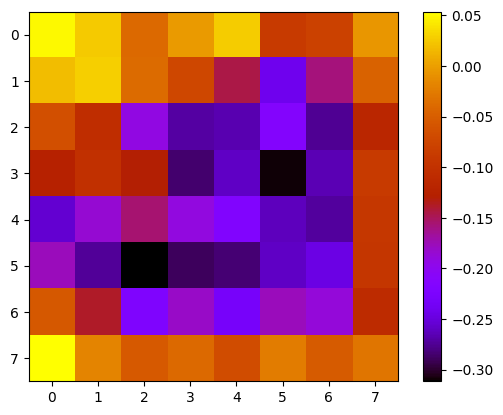

In [31]:
# Testing the Discriminator

inp, tar  = split(loadData("train", 100)[2])
gen_output = generator(inp[tf.newaxis], training=False)
disc_out = discriminator([inp[tf.newaxis, ...], gen_output], training=False)
plt.imshow(disc_out[0, ...],cmap='gnuplot',interpolation="none");
plt.colorbar();

Text(0.5, 1.0, '(1, 8, 8, 1)')

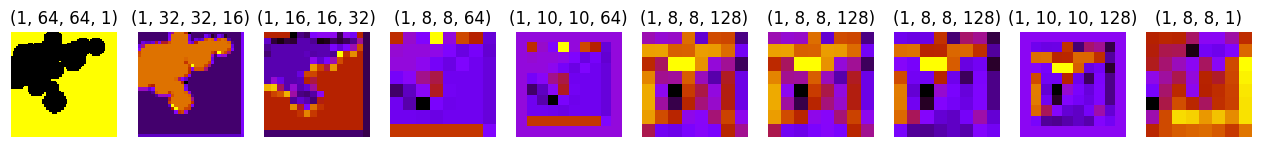

In [32]:
# Defining input
inp, tar  = split(loadData("train", 100)[2])

# Defining Figure
fig, axs = plt.subplots(1,10,figsize=(16, 15))

# Turning axis off
for i in range(10):
    axs[i].axis('off');

axs[0].imshow(inp, cmap="gnuplot", interpolation = "none")
axs[0].set_title(np.shape(tf.expand_dims(inp, 0)))

result = downsample(16, 3)(tf.expand_dims(inp, 0))
axs[1].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[1].set_title(np.shape(result))

result = downsample(32, 3)(result)
axs[2].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[2].set_title(np.shape(result))

result = downsample(64, 3)(result)
axs[3].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[3].set_title(np.shape(result))

result = tf.keras.layers.ZeroPadding2D()(result)
axs[4].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[4].set_title(np.shape(result))

result = tf.keras.layers.Conv2D(
        128, 3, strides=1, kernel_initializer=tf.random_normal_initializer(0.0, 0.02), use_bias=False
    )(
        result
    )  
axs[5].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[5].set_title(np.shape(result))

result = tf.keras.layers.BatchNormalization()(result)
axs[6].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[6].set_title(np.shape(result))

result = tf.keras.layers.LeakyReLU()(result)
axs[7].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[7].set_title(np.shape(result))

result = tf.keras.layers.ZeroPadding2D()(result)  # (batch_size, 10, 10, 128)
axs[8].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[8].set_title(np.shape(result))

result = tf.keras.layers.Conv2D(1, 3, strides=1, kernel_initializer=tf.random_normal_initializer(0.0, 0.02))(
        result
    )
axs[9].imshow(result[0,...,0], cmap="gnuplot", interpolation = "none")
axs[9].set_title(np.shape(result))

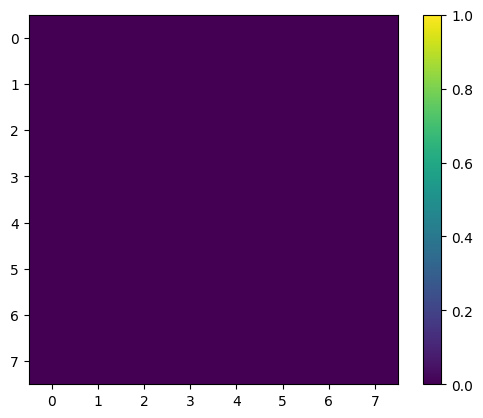

In [33]:
# Defining discriminator Loss

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(disc_real_output, disc_generated_output):
    real_loss = loss_object(tf.ones_like(disc_real_output), disc_real_output)

    generated_loss = loss_object(
        tf.zeros_like(disc_generated_output), disc_generated_output
    )

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss

# Illustrating what zeros_like function do
plt.imshow(tf.zeros_like(disc_out[0,...]),vmin=0, vmax=1, interpolation="none");
plt.colorbar();

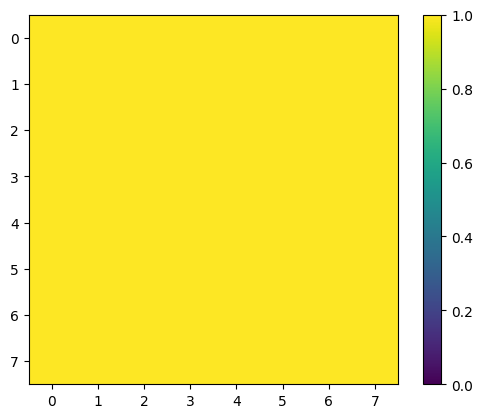

In [34]:
# Defining generator Loss

LAMBDA = 100 # Proportionality factor

def generator_loss(disc_generated_output, gen_output, target):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)  # Gan loss
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))                               # L1 loss
    total_gen_loss = gan_loss + (LAMBDA * l1_loss)                                      # Total: Linear combination 
    return total_gen_loss, gan_loss, l1_loss

# Illustrating what ones_like function do
plt.imshow(tf.ones_like(disc_out[0,...]),vmin=0, vmax=1, interpolation="none")
plt.colorbar();

In [35]:
# Generator and Discriminator optimizers

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [36]:
@tf.function
def train_step(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate Image
        gen_output = generator(input_image, training=True)

        # Discriminator
        disc_real_output = discriminator([input_image, target], training=True)          # Input-Target
        disc_generated_output = discriminator([input_image, gen_output], training=True) # Input-Generated

        # Generator total Loss
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(
            disc_generated_output, gen_output, target
        )
        # Discriminator total Loss
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output)

    # Define gradients
    generator_gradients = gen_tape.gradient(
        gen_total_loss, generator.trainable_variables
    )
    discriminator_gradients = disc_tape.gradient(
        disc_loss, discriminator.trainable_variables
    )

     # Apply gradients
    generator_optimizer.apply_gradients(
        zip(generator_gradients, generator.trainable_variables)
    )
    discriminator_optimizer.apply_gradients(
        zip(discriminator_gradients, discriminator.trainable_variables)
    )

In [37]:
# Select which Losses would you preffer to have computed during training
class compute_losses:
    L1 = True
    L2 = False
    Linf = False
    R2Val = False
    R2Test = False
    R2Train = False  # This is huge
    SSIM = False
    MSSIM = False  # This is huge

In [38]:
for i in range(100):
    folder_name_image = "./ConsoledImages/" + str(i) + "-Val"
    folder_name_losses = "./Losses/" + str(i) + "-Val"
    if not os.path.isdir(folder_name_image):
        os.makedirs(folder_name_image)
    if not os.path.isdir(folder_name_losses):
        os.makedirs(folder_name_losses)

In [39]:


# Initializing losses to be written
l1LossData = [[] for i in range(0, len(validation_dataset))]
l2LossData = [[] for i in range(0, len(validation_dataset))]
linfLossData = [[] for i in range(0, len(validation_dataset))]
MSSIMLossData = [[] for i in range(0, len(validation_dataset))]
SSIMLossData = [[] for i in range(0, len(validation_dataset))]


# Defining a function that will modify the above lists
def ModifySavedList(listName, step, trainSTEP, value):
    listName[step].append(str(trainSTEP) + "," + str(value))


# Initialising R2_Values
R2Val = []
R2Trn = []
R2Test = []


# Defining a function that will modify the above lists
def ModifyR2List(listName, trainSTEP, value):
    listName.append(str(trainSTEP) + "," + str(value))


def WriteInFiles(data_list, name, index, apply_index):
    if apply_index:
        f = open("./Losses/" + str(index) + "-Val/" + str(name) + ".csv", "w")
    else:
        f = open("./Losses/" + str(name) + ".csv", "w")
    f.write("\n".join(data_list))
    f.close()


# This function will write
def WriteAllFiles():
    WriteInFiles(R2Val, "R2Val", 0, False)
    WriteInFiles(R2Trn, "R2Trn", 0, False)
    WriteInFiles(R2Test, "R2Test", 0, False)

    for i in range(len(l1LossData)):
        WriteInFiles(l1LossData[i], "l1", i, True)
        WriteInFiles(l2LossData[i], "l2", i, True)
        WriteInFiles(linfLossData[i], "linf", i, True)
        WriteInFiles(MSSIMLossData[i], "mssim", i, True)
        WriteInFiles(SSIMLossData[i], "ssim", i, True)

# L1 Loss
def l1Loss(predicted, output_image):
    return tf.reduce_sum(tf.abs(output_image - predicted)).numpy()


# L2 Loss
def l2Loss(predicted, output_image):
    return tf.sqrt(tf.reduce_sum(tf.square(output_image - predicted))).numpy()


# L_inf Loss
def linfLoss(predicted, output_image):
    return tf.reduce_max(tf.abs(output_image - predicted)).numpy()


K1 = 0.01
L1 = 64
K2 = 0.01
L2 = 64
C1 = (K1 * L1) ** 2
C2 = (K2 * L2) ** 2


def ssimLoss(predicted, output_image):
    muX = tf.reduce_mean(output_image)
    muY = tf.reduce_mean(predicted)
    sigmaX = tf.sqrt(
        tf.reduce_sum(tf.square(output_image - muX)) / (IMG_WIDTH * IMG_HEIGHT - 1)
    )
    sigmaY = tf.sqrt(
        tf.reduce_sum(tf.square(predicted - muY)) / (IMG_WIDTH * IMG_HEIGHT - 1)
    )
    sigmaXY = tf.reduce_sum(
        tf.math.multiply((predicted - muY), (output_image - muX))
    ) / (IMG_WIDTH * IMG_HEIGHT - 1)
    ssimLoss = (
        (2 * muX * muY + C1)
        * (2 * sigmaXY + C2)
        / ((muX**2 + muY**2 + C1) * (sigmaX**2 + sigmaY**2 + C2))
    )
    return ssimLoss.numpy()


WS = 8  # Window Size
STR = 1  # Stride


# Computing MSSIM
def mSsimLoss(predicted, output_image):
    mssim = []
    for i in range(0, 64 - WS, STR):
        for j in range(0, 64 - WS, STR):
            mssim.append(
                ssimLoss(
                    predicted[:, i : i + WS, j : j + WS, :],
                    output_image[:, i : i + WS, j : j + WS, :],
                )
            )
    return np.mean(mssim)


# Computing mean values for charge densities and potentials
def ComputeDataSetsMeanValues(data_set, quantity, target):
    input_mean = 0
    target_mean = 0
    for step, (inp, tar) in enumerate(data_set):
        if step == 0:
            input_mean = inp
            target_mean = tar
        else:
            input_mean += inp
            target_mean += tar
    if target:
        return target_mean / quantity
    else:
        return input_mean / quantity


validation_mean_value = ComputeDataSetsMeanValues(validation_dataset, 100, True)
test_mean_value = ComputeDataSetsMeanValues(test_dataset, 100, True)
train_mean_value = ComputeDataSetsMeanValues(train_dataset, 4800, True)


# Computing R2 coefficient
def R2Computer(data_set, meanValue):
    ssRes = 0
    ssTot = 0
    for step, (inp, tar) in enumerate(data_set):
        pred = generator(inp, training=False)
        ssRes += tf.reduce_sum(tf.square(tar - pred)).numpy()
        ssTot += tf.reduce_sum(tf.square(tar - meanValue)).numpy()

    return 1 - (ssRes / ssTot)


def ComputeLosses(trainSTEP):
    if compute_losses.R2Val:
        ModifyR2List(
            R2Val, trainSTEP, R2Computer(validation_dataset, validation_mean_value)
        )
    if compute_losses.R2Test:
        ModifyR2List(R2Test, trainSTEP, R2Computer(test_dataset, test_mean_value))
    if compute_losses.R2Train:
        ModifyR2List(R2Trn, trainSTEP, R2Computer(train_dataset, train_mean_value))

    for step, (inp, tar) in enumerate(validation_dataset.take(20)):
        # Predicting charge density from potential
        pred = generator(inp, training=False)

        if compute_losses.L1:
            ModifySavedList(l1LossData, step, trainSTEP, l1Loss(pred, tar))
        if compute_losses.L2:
            ModifySavedList(l2LossData, step, trainSTEP, l2Loss(pred, tar))
        if compute_losses.Linf:
            ModifySavedList(linfLossData, step, trainSTEP, linfLoss(pred, tar))
        if compute_losses.SSIM:
            ModifySavedList(SSIMLossData, step, trainSTEP, ssimLoss(pred, tar))
        if compute_losses.MSSIM:
            ModifySavedList(MSSIMLossData, step, trainSTEP, mSsimLoss(pred, tar))


# A funtion that convert tensor of rank 2 into text
def Tensor2Text(tensor):
    text = []
    for row in tensor.numpy()[0]:
        column = []
        for col in row:
            column.append(str(col[0]))
        text.append(",".join(column))
    return "\n".join(text)


# Saving images
def WriteTensors(trainSTEP):
    for step, (inp, tar) in enumerate(test_dataset):
        pred = generator(inp, training=False)
        err = tf.abs(tar - pred)
        imagesData = "\n".join([Tensor2Text(i) for i in [inp, tar, pred, err]])
        f = open(
            "./ConsoledImages/" + str(step) + "-Val/" + str(trainSTEP) + ".csv",
            "w",
        )
        f.write(imagesData)
        f.close()



In [40]:
# Fitting
def fit(train_ds, steps):  # inputImage = tf.data.Dataset.from_tensor_slices(inputImage)
    # inputImage = inputImage.map(normalize)
    # inputImage = inputImage.batch(1)
    # for inp in inputImage:
    #     prediction = generator(inp, training=True).numpy()
    # prediction = prediction.reshape(64, 64)
    # prediction = (prediction + 1) / 2
    start = time.time()
    for step, (input_image, target) in train_ds.repeat().take(steps).enumerate():
        if (step) % 1000 == 0:                 # At each 1000 steps, clear row
            display.clear_output(wait=True)

            if step != 0:
                print(f"Time taken for 1000 steps: {time.time()-start:.2f} sec\n")   # Compute how much 1000 steps take

            start = time.time()
            print(f"Step: {step//1000}k")

        if step % 50 == 0:
            #WriteTensors(str(step.numpy()))
            ComputeLosses(str(step.numpy()))             # Computing losses at each 50 steps

        train_step(input_image, target, step)            # Calling the training function for one step

        # Training step
        if (step + 1) % 10 == 0:                         # Print a dot at each 10 steps
            print(".", end="", flush=True)
            


In [41]:
#  Fitting the data 
fit(train_dataset, steps=2000)

Time taken for 1000 steps: 30.05 sec

Step: 1k
....................................................................................................

In [42]:
# Write all errors
WriteAllFiles()

<_ZipDataset element_spec=(TensorSpec(shape=(), dtype=tf.int64, name=None), (TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)))>


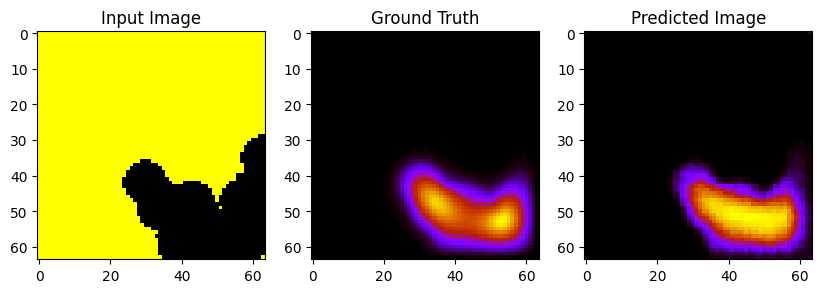

In [53]:
# Testing the model on test_dataset

index = 30
print( test_dataset.take(100).enumerate())
for  step, (inp, tar) in enumerate(test_dataset.take(100)):
    if step == index:
        prediction = generator(inp, training=True)
        plt.figure(figsize=(10, 10))

        display_list = [inp[0], tar[0], prediction[0]]
        title = ['Input Image', 'Ground Truth', 'Predicted Image']

        for i in range(3):
            plt.subplot(1, 3, i+1)
            plt.title(title[i])
            plt.imshow(display_list[i], interpolation="None", cmap = 'gnuplot');
plt.show();

In [49]:
# Save the Generator

generator.save("./generatorCheck2.h5")